In [43]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, Lasso
from skopt import BayesSearchCV
import skopt.space as space
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

In [44]:
from ff_custom_scripts import *

train, test,leaderboard,holdout = load_files(nanvalues='remove')

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


# Model

In [47]:
def run_model(train, target='gpa', classifier=False):
    X_train, y_train = prepare_data(train, target)
    print(f'{X_train.shape[1]} features selected for {target}')

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),

    ])

    ordered_transformer = Pipeline(steps=[
        ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer', KNNImputer(n_neighbors=5)),
    ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    categorical_features = cols_per_type(X_train, 'Ordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    ordinal_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of ordinal features: {len(ordinal_features)}')

    search_space = {
        'regressor__max_iter': space.Integer(10_000, 20_000),
    }

    if classifier:
        model = LogisticRegression(penalty='l1', solver='liblinear')

        score = 'neg_brier_score'

        preprocessor = make_column_transformer(
            (categorical_transformer, categorical_features),
            (numeric_transformer, numerical_features),
            (ordered_transformer, ordinal_features),
            (ordered_transformer, binary_features)
        )

        pipes = imbPipeline(steps=[('preprocessor', preprocessor),
                                   ('smote', SMOTE(random_state=24)),
                                   ('regressor', model)])

    else:
        model = Lasso()

        score = 'neg_mean_squared_error'

        search_space.update({
            'regressor__alpha': space.Real(5_00, 1_500),
        })

        preprocessor = make_column_transformer(
            (categorical_transformer, categorical_features),
            (numeric_transformer, numerical_features),
            (ordered_transformer, ordinal_features),
            (ordered_transformer, binary_features)
        )

        pipes = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', model)])

    model = BayesSearchCV(
        pipes,
        search_space,
        cv=5,
        n_iter=10,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    return model


# GPA

In [48]:
gpa_model = run_model(train,target='gpa', classifier=False)

1204 features selected for gpa
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [65]:
score_model(gpa_model,'gpa',test,leaderboard,holdout=None,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4094
Standard deviation of CV scores: 0.0360
Mean CV score: 0.4107
Test MSE: 0.3949
Test R2: 0.1269
>> Leaderboard MSE: 0.3857
Leaderboard R2: 0.0126


# Material Hardship

In [50]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

1204 features selected for materialHardship
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [51]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.0226
Standard deviation of CV scores: 0.0038
Mean CV score: 0.0235
Test MSE: 0.0243
Test R2: 0.0390
>> Leaderboard MSE: 0.0278
Leaderboard R2: 0.0281


# Grit


In [52]:
model_grit = run_model(train,target='grit', classifier=False)

1204 features selected for grit
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [53]:
model_grit.best_params_

OrderedDict([('regressor__alpha', 503.63030725474323),
             ('regressor__max_iter', 18178)])

In [66]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2347
Standard deviation of CV scores: 0.0377
Mean CV score: 0.2353
Test MSE: 0.2257
Test R2: -0.0061
>> Leaderboard MSE: 0.2214
Leaderboard R2: -0.0075


# Eviction

In [55]:
model_eviction = run_model(train,target='eviction', classifier=True)

1204 features selected for eviction
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [56]:
score_model(model_eviction,'eviction', test, leaderboard, holdout=None,classifier=True)

Scores without threshold adjusment
Test Brier: 0.0822
Test F1: 0.0000
Leaderboard Brier: 0.0962
Number of positive predictions: 31.0
>> Leaderboard F1: 0.1639
Leaderboard Accuracy: 0.9038
Leaderboard Recall: 0.1667


Scores with threshold adjusment


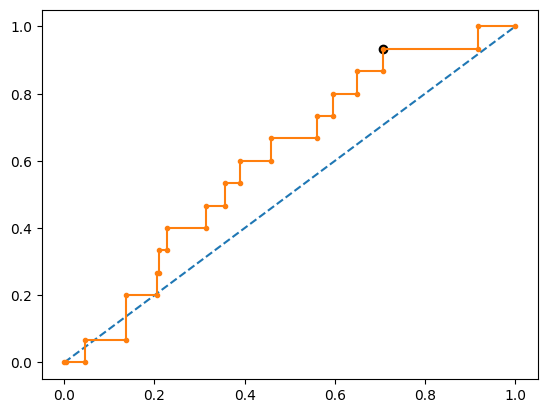

Threshold=0.000, FPR=0.708, TPR=0.933
Test brier: 0.678
Test F1: 0.116
Leaderboard Brier: 0.713
              precision    recall  f1-score   support

         0.0       0.96      0.26      0.40       500
         1.0       0.06      0.80      0.11        30

    accuracy                           0.29       530
   macro avg       0.51      0.53      0.26       530
weighted avg       0.90      0.29      0.39       530

Leaderboard F1: 0.113


In [57]:
score_classifier(model_eviction, 'eviction', test, leaderboard, holdout=None)

# jobTraining

In [58]:
model_job = run_model(train,target='jobTraining', classifier=True)

1204 features selected for jobTraining
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [68]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None,classifier=True)

Scores without threshold adjusment
Test Brier: 0.3082
Test F1: 0.3571
Leaderboard Brier: 0.3811
Number of positive predictions: 159.0
>> Leaderboard F1: 0.3399
Leaderboard Accuracy: 0.6189
Leaderboard Recall: 0.3537


Scores with threshold adjusment


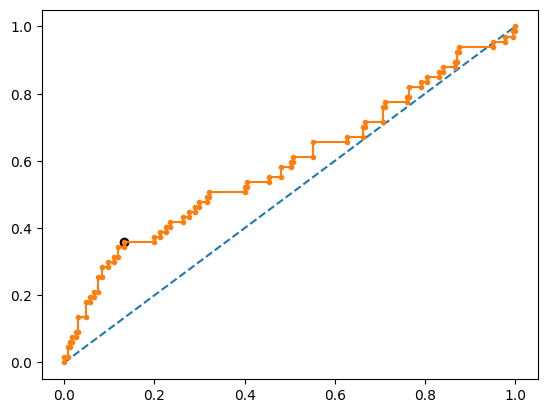

Threshold=0.856, FPR=0.133, TPR=0.358
Test brier: 0.253
Test F1: 0.383
Leaderboard Brier: 0.338
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       383
         1.0       0.35      0.25      0.29       147

    accuracy                           0.66       530
   macro avg       0.54      0.54      0.54       530
weighted avg       0.63      0.66      0.64       530

Leaderboard F1: 0.292


In [60]:
score_classifier(model_job, 'jobTraining', test, leaderboard, holdout=None)


# Layoff

In [61]:
model_layoff = run_model(train, target='layoff', classifier=True)

1204 features selected for layoff
N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [62]:
model_layoff.best_params_

OrderedDict([('regressor__max_iter', 17996)])

In [63]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.3267
Test F1: 0.2807
Leaderboard Brier: 0.3679
Number of positive predictions: 128.0
>> Leaderboard F1: 0.2105
Leaderboard Accuracy: 0.6321
Leaderboard Recall: 0.2185


Scores with threshold adjusment


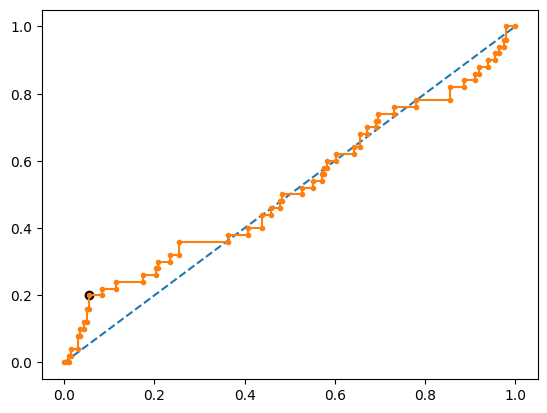

Threshold=0.937, FPR=0.055, TPR=0.200
Test brier: 0.207
Test F1: 0.257
Leaderboard Brier: 0.285
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83       411
         1.0       0.21      0.10      0.14       119

    accuracy                           0.72       530
   macro avg       0.49      0.50      0.48       530
weighted avg       0.65      0.72      0.67       530

Leaderboard F1: 0.137


In [64]:
score_classifier(model_layoff, 'layoff', test, leaderboard, holdout=None)